In [1]:
from mri.ExplainableAI import *
import matplotlib.pyplot as plt

#### Load trained models from Gatshub

In [2]:
import mlflow
import os

# Set the tracking URI for your DagsHub repository
mlflow.set_tracking_uri("https://dagshub.com/samisena/MRI_VScode.mlflow")

# Set your DagsHub credentials
os.environ['MLFLOW_TRACKING_USERNAME'] = 'samisena'
os.environ['MLFLOW_TRACKING_PASSWORD'] = 'cb6584b07822e49dbde524fb92b0376756fcfdfd'

run_id = "4a013ab305c843f1a5b073e13387c25f"
model_uri = f"runs:/{run_id}/final_model_resnet50"

loaded_model = mlflow.pytorch.load_model(model_uri, map_location=torch.device('cpu'))

# Set to evaluation mode
loaded_model.eval()
print("Model loaded successfully!")


c:\ProgramData\anaconda3\envs\myvenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025/04/18 12:15:11 WARNING mlflow.pytorch: Stored model version '2.2.1+cu121' does not match installed PyTorch version '2.5.1'


Model loaded successfully!


### Inference

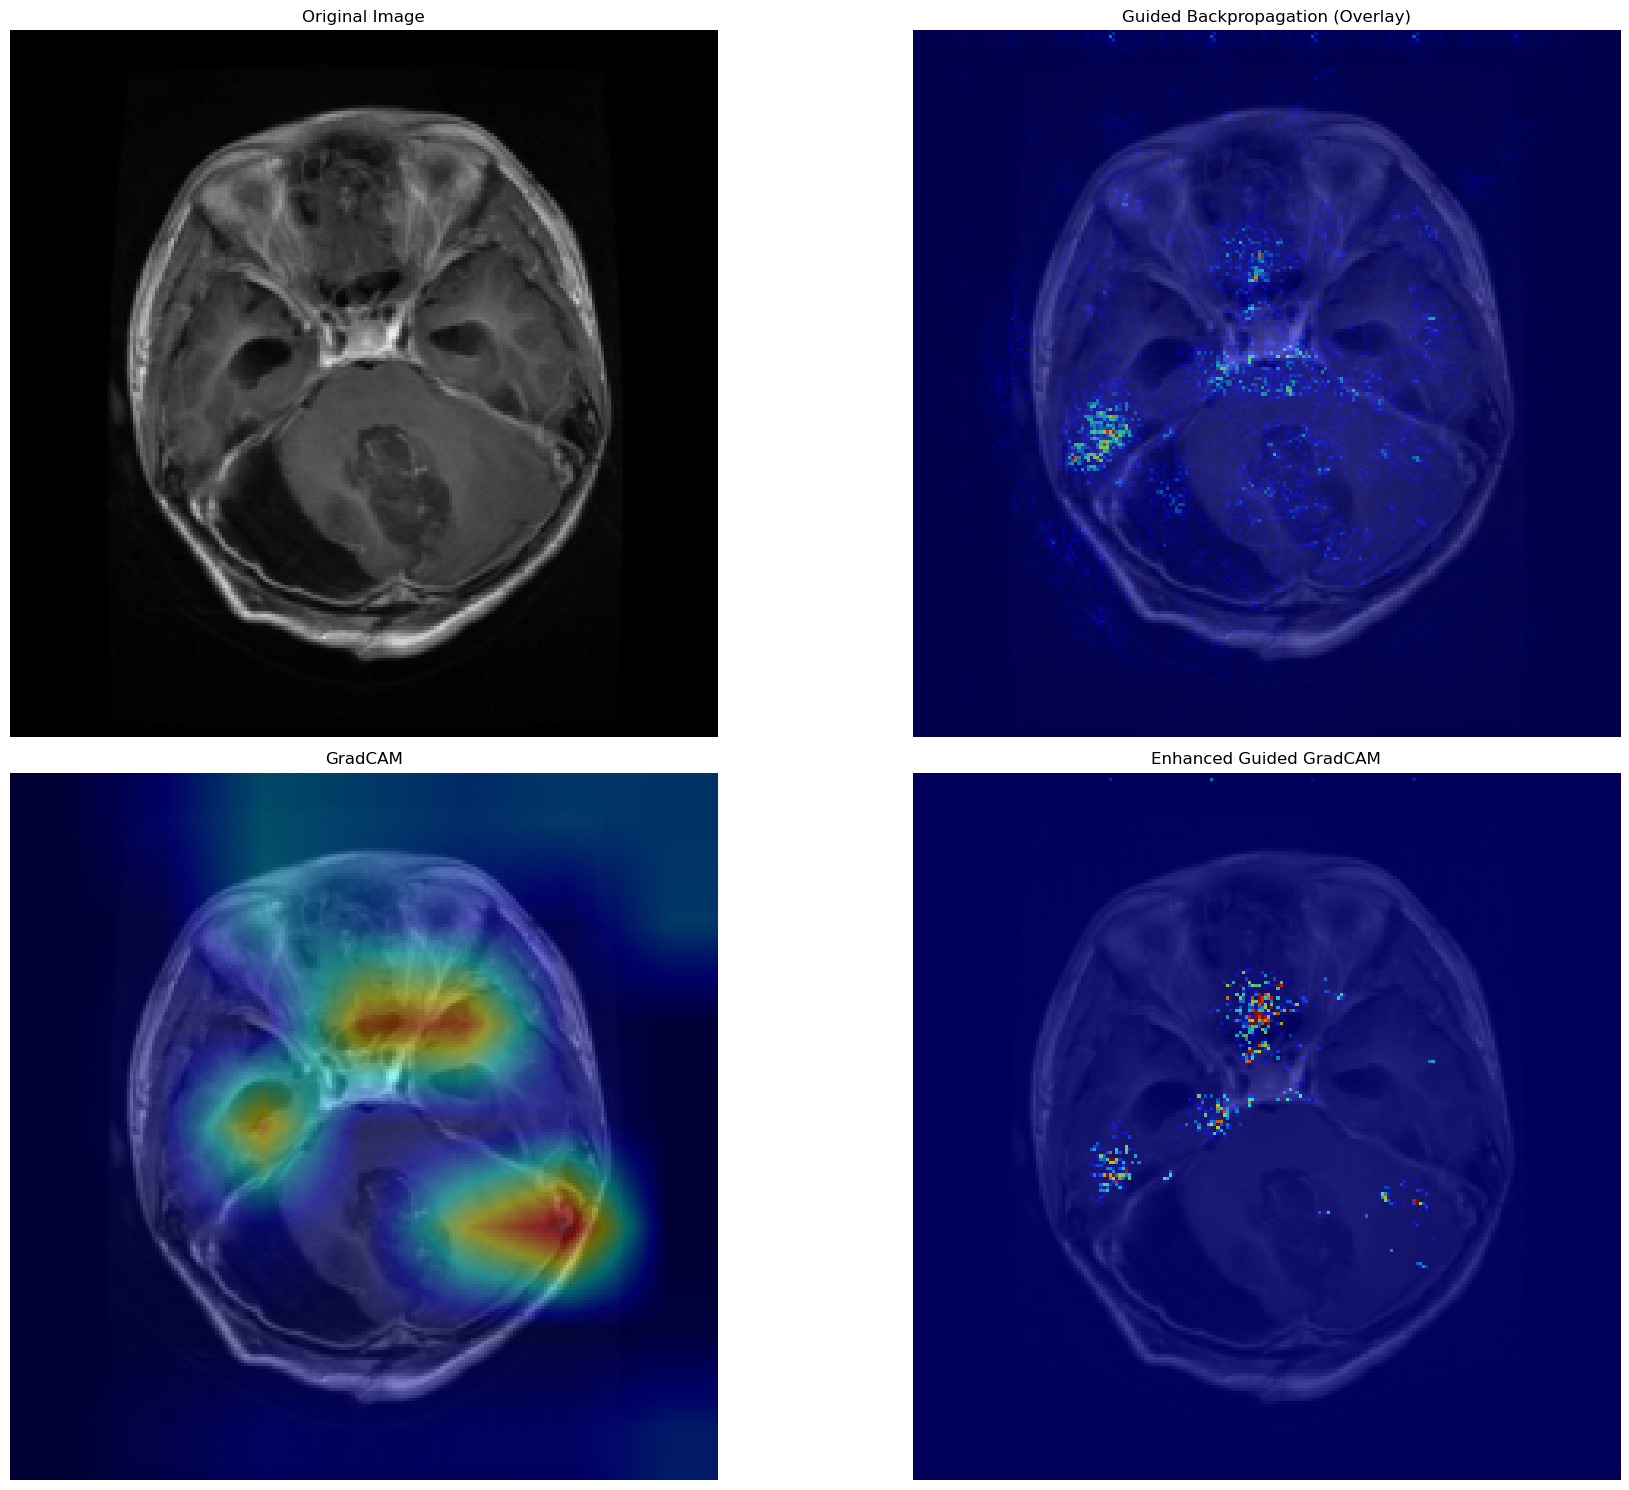

In [ ]:
# Your input setup
inputs, _ = next(iter(test_loader))
input_tensor = inputs[0].unsqueeze(0)

# Replace with your target layer
# For ResNet50, a good choice is often the last convolutional layer
target_layer = "resnet.layer4"

# Now let's visualize all three methods with enhancements

# 1. Get the original image for reference
original_img = tensor_to_image(input_tensor)

# 2. Enhanced Guided Backpropagation with overlay
guided_bp_result = enhanced_guided_backprop(loaded_model, input_tensor, alpha=0.6)

# 3. GradCAM
gradcam_result = gradcam(loaded_model, target_layer, input_tensor)

# 4. Enhanced Guided GradCAM with more vibrant colors
guided_gradcam_result = enhanced_guided_gradcam(
    loaded_model, target_layer, input_tensor,  
    alpha=0.7, colormap=cv2.COLORMAP_JET, 
    brightness_factor=2.5, contrast_factor=2.0
)

# Create a figure with all visualizations
plt.figure(figsize=(20, 15))

# Original image
plt.subplot(2, 2, 1)
plt.title("Original Image")
plt.imshow(original_img)
plt.axis("off")

# Enhanced Guided Backpropagation (with overlay)
plt.subplot(2, 2, 2)
plt.title("Guided Backpropagation")
plt.imshow(guided_bp_result['overlay'])
plt.axis("off")

# GradCAM
plt.subplot(2, 2, 3)
plt.title("GradCAM")
plt.imshow(gradcam_result['overlay'])
plt.axis("off")

# Enhanced Guided GradCAM
plt.subplot(2, 2, 4)
plt.title("Enhanced Guided GradCAM")
plt.imshow(guided_gradcam_result['enhanced_overlay'])
plt.axis("off")

plt.tight_layout()
plt.show()